In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch

In [9]:
def R(theta): #rotation matrix at angle theta
    return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

def generate_batch(batch_size,n_sides,edge_length_range=(40,60),edge_width=2,center_mean=(64,64),center_std=5):
    #batch_size: number of images to generate
    #n_sides number of sides of the full polygon (generated images may have fewer sides)
    imgs=[]
    for _ in range(batch_size):
    
        image=np.zeros((128,128))

        center=center_mean+center_std*np.random.randn(2)
        edge_length=np.random.uniform(low=edge_length_range[0],high=edge_length_range[1])
        theta0=np.random.rand()*2*np.pi
        vertices=np.array([np.dot(R(theta+theta0),edge_length*np.array([1,0])) for theta in np.linspace(0,2*np.pi,n_sides,endpoint=False)])+center
        
        n_sides_cur=np.random.choice(np.arange(2, n_sides+1)) #number of sides for this image
        vertices=np.vstack((vertices,vertices[0]))[:n_sides_cur+1] #+1 is bc if there are 2 sides, then we need 3 points
        
        for v,vnext in zip(vertices[:-1],vertices[1:]):
            image=cv2.line(image, tuple(v.astype('int')), tuple(vnext.astype('int')), (255), edge_width)
        imgs.append(image)
    return np.stack(imgs)

train_imgs=[]
train_labels=[]
test_imgs=[]
test_labels=[]
sides_range=[3,4,5,6,7,8,9,10] #images will be polygons with number of sides being one of the numbers in this list

n_train=1500 #number of training images in each class
n_test=500
for class_id,n_sides in enumerate(sides_range):
    imgs=generate_batch(n_train+n_test,n_sides,edge_width=2)
    train_imgs.append(imgs[:n_train])
    test_imgs.append(imgs[n_train:])
    train_labels+=[class_id]*n_train
    test_labels+=[class_id]*n_test
train_imgs=np.vstack(train_imgs)
test_imgs=np.vstack(test_imgs)
train_labels=np.array(train_labels)
test_labels=np.array(test_labels)

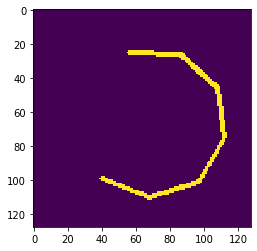

In [10]:
plt.imshow(train_imgs[np.random.choice(len(train_imgs))]) #show image from training set 


In [21]:
class CNN(torch.nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()

        self.n_classes=n_classes
        # Convolution 1
        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=8, stride=1, padding=3)
        self.relu1 = torch.nn.ReLU()

        # Max pool 1
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=4)

        self.bn1 = torch.nn.BatchNorm2d(20)


        # Fully connected 1 (readout)
        self.fc1=torch.nn.Linear(19220,self.n_classes)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out=self. bn1(out)
        out = self.maxpool1(out)
        
        out = out.view(out.size(0), -1)
        
        out = torch.nn.functional.softmax(self.fc1(out), dim=1)
        return out

    


In [22]:
m=CNN(len(sides_range))

In [23]:
losses = []


In [70]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(m.parameters(), lr=.005)

# initiaze training target as K-column binary array, where K is the number of output classes of the network
target = torch.zeros(train_imgs.shape[0], len(sides_range))
for i, l in enumerate(train_labels):
    target[i, l] = 1

m.train()
n_grad_updates=3000 
batch_size=64
for _ in range(n_grad_updates):
    batch_ids = np.random.choice(train_imgs.shape[0], batch_size, replace=False)
    optimizer.zero_grad()
    #reshape input to size (n examples, n channels (=1), image width, image height)
    y_pred = m.forward(torch.from_numpy(train_imgs[batch_ids, :]).float().unsqueeze(1)) 
    loss = criterion(y_pred.squeeze(), target[batch_ids, :])
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

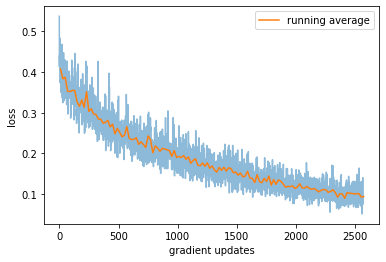

In [71]:
plt.plot(losses,alpha=.5)
window_size=20
losses_av=[np.mean(losses[i:i+window_size]) for i in np.arange(0,len(losses),window_size)]
plt.plot(np.arange(0,len(losses),window_size)+window_size/2,losses_av,label='running average')
plt.legend()
plt.xlabel('gradient updates')
plt.ylabel('loss')

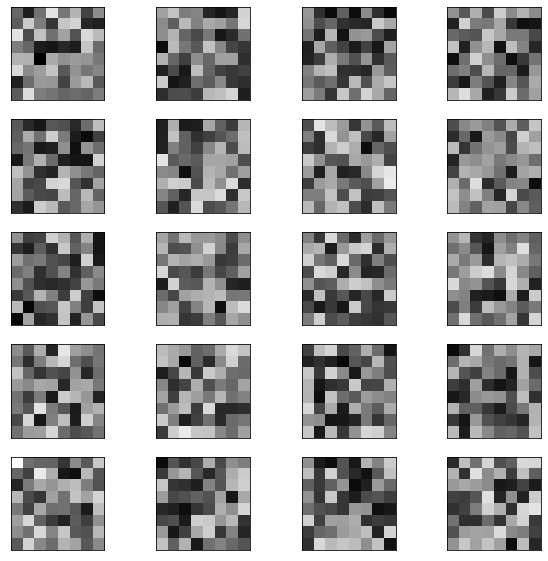

In [72]:
#show the learned filters
filters=list(m.parameters())[0].detach().numpy().squeeze()

plt.figure(figsize=(10,10))
subplot_id=1
max_rows=4
max_cols=5
vmin=np.min(filters)
vmax=np.max(filters)
subplot_id=1
for j in range(max_cols):
    for i in range(max_rows):
        if(subplot_id>len(filters)):
            break
        plt.subplot(max_cols,max_rows,subplot_id)
        plt.imshow(filters[subplot_id-1,:,:],cmap='binary',vmin=vmin,vmax=vmax)
        subplot_id+=1
        plt.xticks([])
        plt.yticks([])
        #plt.title(str(i)+','+str(j))
#plt.tight_layout()

In [73]:
m.eval()

N=300 #randomly pick this many training images to estimate training accuracy 
rp=np.random.permutation(len(train_imgs))[:N]
train_preds=torch.argmax(m.forward(torch.from_numpy(train_imgs[rp]).float().unsqueeze(1)),axis=1).detach().numpy()
preds=torch.argmax(m.forward(torch.from_numpy(test_imgs).float().unsqueeze(1)),axis=1).detach().numpy()

In [74]:
np.mean(train_preds==train_labels[rp]) #train accuracy 

0.85

In [75]:
np.mean(preds==test_labels) #test accuracy

0.55125

(-0.5, 9)

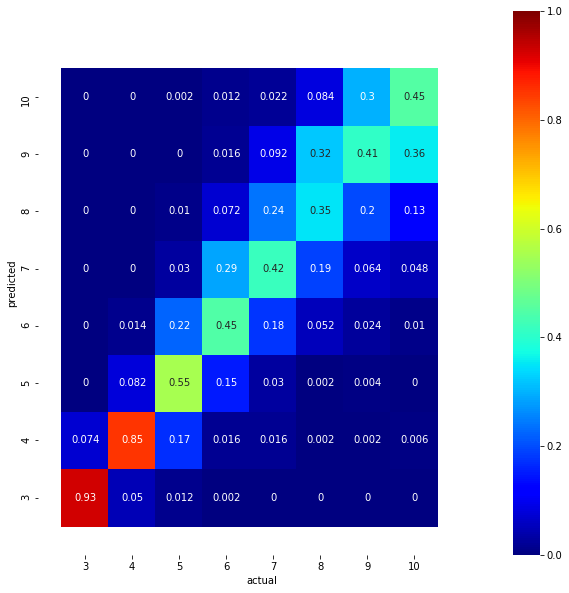

In [76]:
#confusion matrix 
plt.figure(figsize=(10,10))
C=np.histogram2d(preds,test_labels,bins=np.arange(-.5,len(sides_range)+.5,1))[0]
Cn=C/np.sum(C,axis=0)[np.newaxis,:] #normalize each column to sum to 1
import seaborn as sns
sns.heatmap(Cn,vmin=0,vmax=1,annot=True,cmap='jet')
plt.ylabel('predicted')
plt.xlabel('actual')
plt.xticks(np.arange(C.shape[0])+.5,sides_range)
plt.yticks(np.arange(C.shape[0])+.5,sides_range)
plt.ylim(-.5,len(sides_range)+1)
plt.xlim(-.5,len(sides_range)+1)
